Uncomment this section if imports below fail

In [5]:

# %pip install tensorflow
# %pip install keras
# %pip install matplotlib
# %pip install opencv-python opencv-python-headless
# !pip install -U scikit-learn


In [6]:
# Get data from kaggle 
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images
# ! unzip lung-and-colon-cancer-histopathological-images.zip

#Install Seaborn
# !pip3 install seaborn 

# !pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Python312\Lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [7]:

import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout,InputLayer
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from cv2 import imread,resize
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

# Data preparation
From the data set we have 5000 images from each class and to make sure that we are taking the right amount for our training and testing data we need to section this 5000x5 into evenly split training and testing data. To do this we are going to take 80% of the data for training and using the last 20% of the data for testing. This comes out to 5000*.8= 4000 images per classification for training and 5000*.2 images per classification for testing. This comes out to a total of 20,000 images to train on and 5000 images to test on. The following code will represent how that will be taken place

## Load in Data

(768, 768, 3)

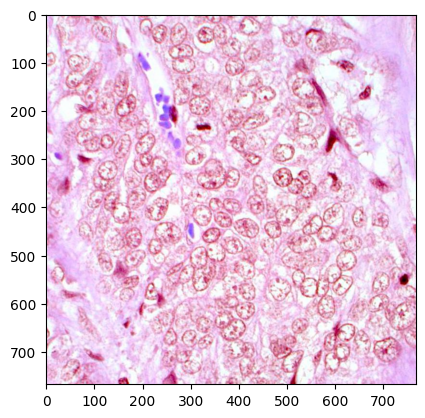

In [9]:
# Find out the dims of our images
img = imread(os.path.join('lung_colon_image_set','colon_aca','colonca1.jpeg'))
plt.imshow(img)
img.shape

In [10]:
# Get classifications from the strucutre of the directory
# Classifications = os.listdir('lung_colon_image_set')
classifications = ['colon_aca','colon_n','lung_aca','lung_n','lung_scc']

# Load the data
data = tf.keras.utils.image_dataset_from_directory('lung_colon_image_set',class_names=classifications,shuffle=True, image_size=(768,768),batch_size=32,labels='inferred')

Found 25000 files belonging to 5 classes.


# Lets look at the data and see what it looks like 

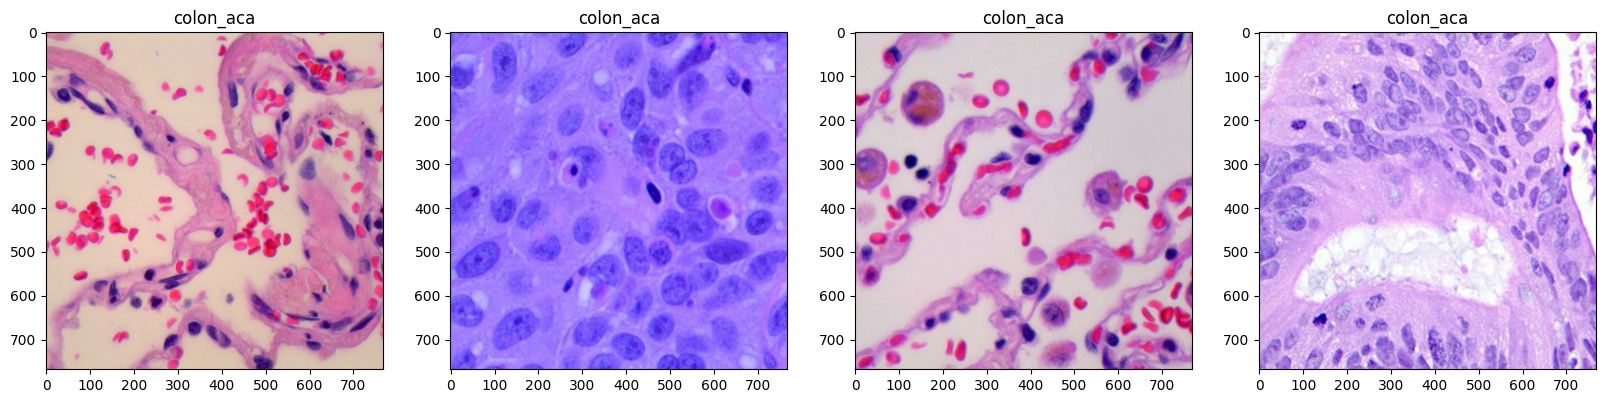

In [11]:
data_iterator = data.as_numpy_iterator()

batch = next(data_iterator)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(classifications[np.argmax(batch[1][idx], axis=-1)])
plt.show()

## Image preprocessing
Adding random transfromations to the data to improve accuracy 

In [12]:
# Define your transformations
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Load images from the disk, applies data augmentation, and rescales the images
data_iterator = data_gen.flow_from_directory(
    'lung_colon_image_set',
    target_size=(768, 768),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

Found 25000 images belonging to 5 classes.


## Split the data

In [13]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [14]:
train_size

547

In [15]:
img = next(data_iterator)[0][0]
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [16]:
layers = [
        InputLayer(shape=img.shape),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(.001),
        Dense(5, activation='softmax')]
model = Sequential(layers)
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=img.shape))
# model.add(MaxPooling2D())
# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [17]:
learning_rate = .001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
recompute = True
if os.path.exists('Cancer_CNN_weights.keras') and recompute == False:
    model = load_model('Cancer_CNN_weights.keras')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 766, 766, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 766, 766, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 383, 383, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 381, 381, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 381, 381, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 190, 190, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2310400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   295,731,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,751,749 (1.10 GB)

 Trainable params: 295,751,557 (1.10 GB)

 Non-trainable params: 192 (768.00 B)

# Training
The fun part about seeing if the model works well :smiley:

In [19]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
if os.path.exists('Cancer_CNN_weights.keras') and recompute == False:
    print('Loaded past weights')
    hist = None
else:
    print('Fitting Model and saving weights')
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback],batch_size=32)
    model.save('Cancer_CNN_weights.keras')
    hist_json_file = 'history.json' 
    json.dump(str(hist.history), open(hist_json_file, 'w'))

Fitting Model and saving weights
Epoch 1/20
 63/547 ━━━━━━━━━━━━━━━━━━━━ 41:47:42 311s/step - accuracy: 0.6308 - loss: 147.4938

In [ ]:

if hist:
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
else:
    print('No history to plot loss')

No history to plot


In [ ]:
if hist:
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
else:
    print('No history to plot accuracy')

No history to plot accuracy


In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

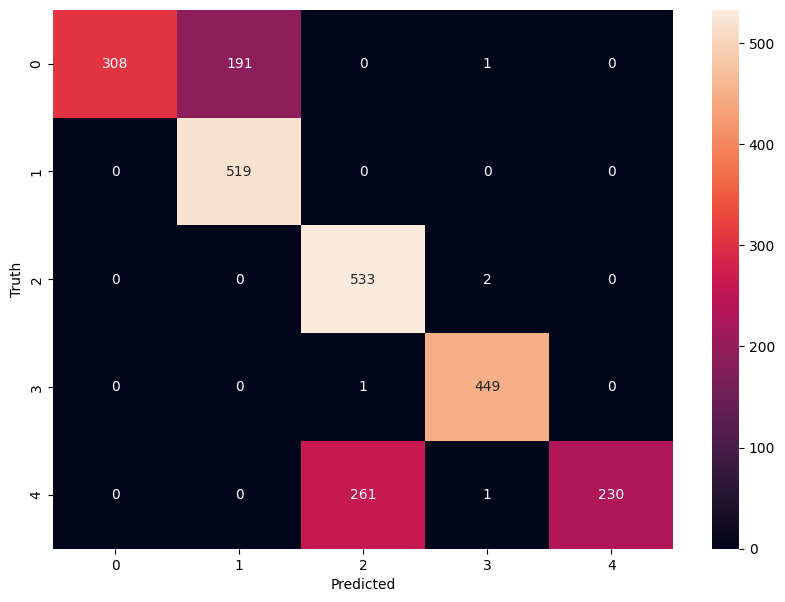

In [ ]:

y_true = []
y_pred = []

for imgs, ys in test:
    # Make a prediction for the entire batch
    yhats = model.predict(imgs)
    
    # Convert the predictions to class indices
    yhats = np.argmax(yhats, axis=-1)

    y_true.extend([classifications[x] for x in ys.numpy().tolist()])
    y_pred.extend([classifications[x] for x in yhats.tolist()])


    
    # Update the metrics
    pre.update_state(ys, yhats)
    re.update_state(ys, yhats)
    acc.update_state(ys, yhats)

cm = confusion_matrix(y_true, y_pred)


# Print the final results
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [ ]:


print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9123021, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.33293268, shape=(), dtype=float32)


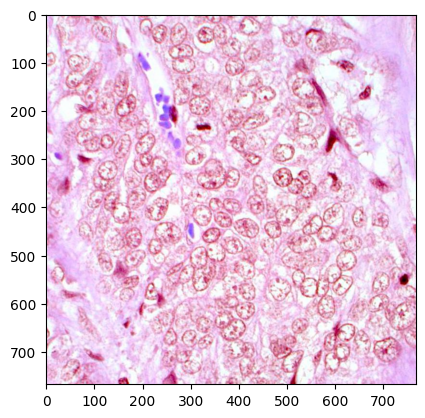

In [ ]:
img = imread(os.path.join('lung_colon_image_set','colon_aca','colonca1.jpeg'))
plt.imshow(img)
plt.show()

In [ ]:
# yhat = model.predict(img)

# yhat

actual = 'lung_n'
img = imread(os.path.join('lung_colon_image_set',actual,'lungn403.jpeg'))
img = resize(img, (256,256))
img = np.expand_dims(img, axis=0)
yhat = model.predict(img)
yhat
print(yhat)
max_idx = np.argmax(yhat)
print(f'predicted: {classifications[max_idx]} actual: {actual}')




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0. 1. 0. 0. 0.]]
predicted: colon_n actual: lung_n
